In [6]:
import pandas as pd

In [7]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier



import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
df = pd.read_csv('sentiment_analysis.csv')
df.head()

,Year,Month,Day,Time of Tweet,text,sentiment,Platform
0,2018,8,18,morning,What a great day!!! Looks like dream.,positive,Twitter
1,2018,8,18,noon,"I feel sorry, I miss you here in the sea beach",positive,Facebook
2,2017,8,18,night,Don't angry me,negative,Facebook
3,2022,6,8,morning,We attend in the class just for listening teac...,negative,Facebook
4,2022,6,8,noon,"Those who want to go, let them go",negative,Instagram


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499 entries, 0 to 498
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Year           499 non-null    int64 
 1   Month          499 non-null    int64 
 2   Day            499 non-null    int64 
 3   Time of Tweet  499 non-null    object
 4   text           499 non-null    object
 5   sentiment      499 non-null    object
 6   Platform       499 non-null    object
dtypes: int64(3), object(4)
memory usage: 27.4+ KB


In [10]:
df.sentiment.value_counts()


sentiment
neutral     199
positive    166
negative    134
Name: count, dtype: int64

In [11]:
df.sentiment.value_counts(normalize=True)


sentiment
neutral     0.398798
positive    0.332665
negative    0.268537
Name: proportion, dtype: float64

In [12]:
df['Platform'] = df['Platform'].str.strip() # Remove trailing and tailing space

In [13]:
df.Platform.value_counts()


Platform
Instagram    171
Facebook     169
Twitter      159
Name: count, dtype: int64

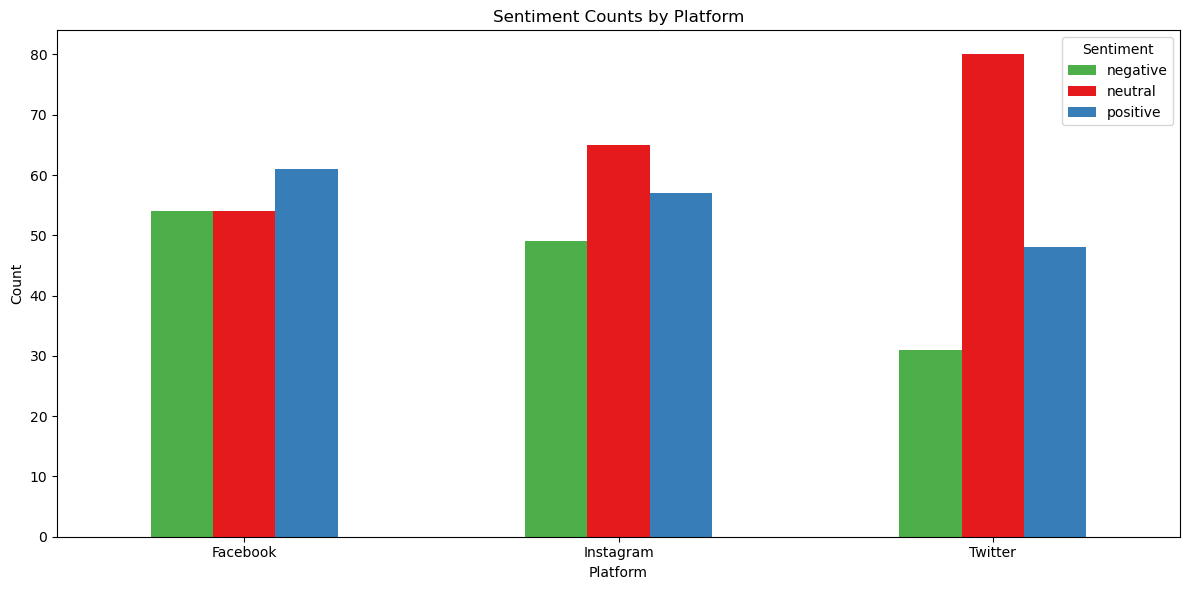

In [14]:
pivot_data = df.groupby(['Platform', 'sentiment']).size().unstack(fill_value=0)

custom_colors = ['#4daf4a', '#e41a1c', '#377eb8']

# Plot the grouped bar chart using the custom colors
ax = pivot_data.plot(kind='bar', figsize=(12, 6), color=custom_colors)
plt.xlabel('Platform')
plt.ylabel('Count')
plt.title('Sentiment Counts by Platform')
plt.xticks(rotation=0)
plt.legend(title='Sentiment')
plt.tight_layout()
plt.show()

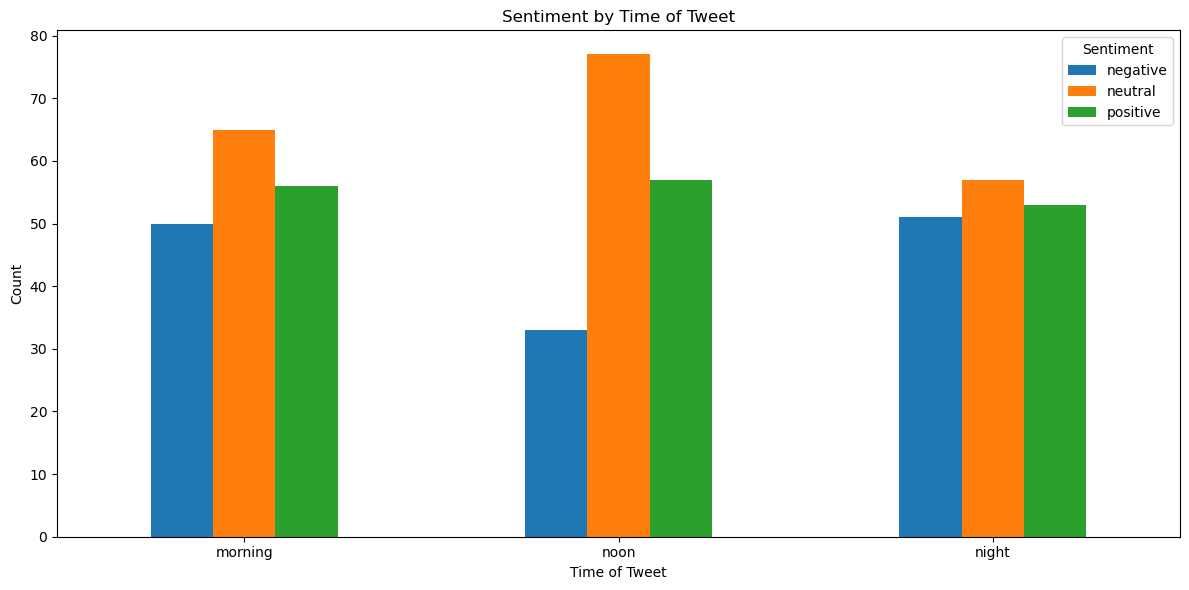

In [15]:
pivot_time = df.groupby(['Time of Tweet', 'sentiment']).size().unstack(fill_value=0)

time_order = ['morning', 'noon', 'night']
pivot_time = pivot_time.reindex(time_order)

pivot_time.plot(kind='bar', figsize=(12, 6))
plt.ylabel('Count')
plt.title('Sentiment by Time of Tweet')
plt.legend(title='Sentiment')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

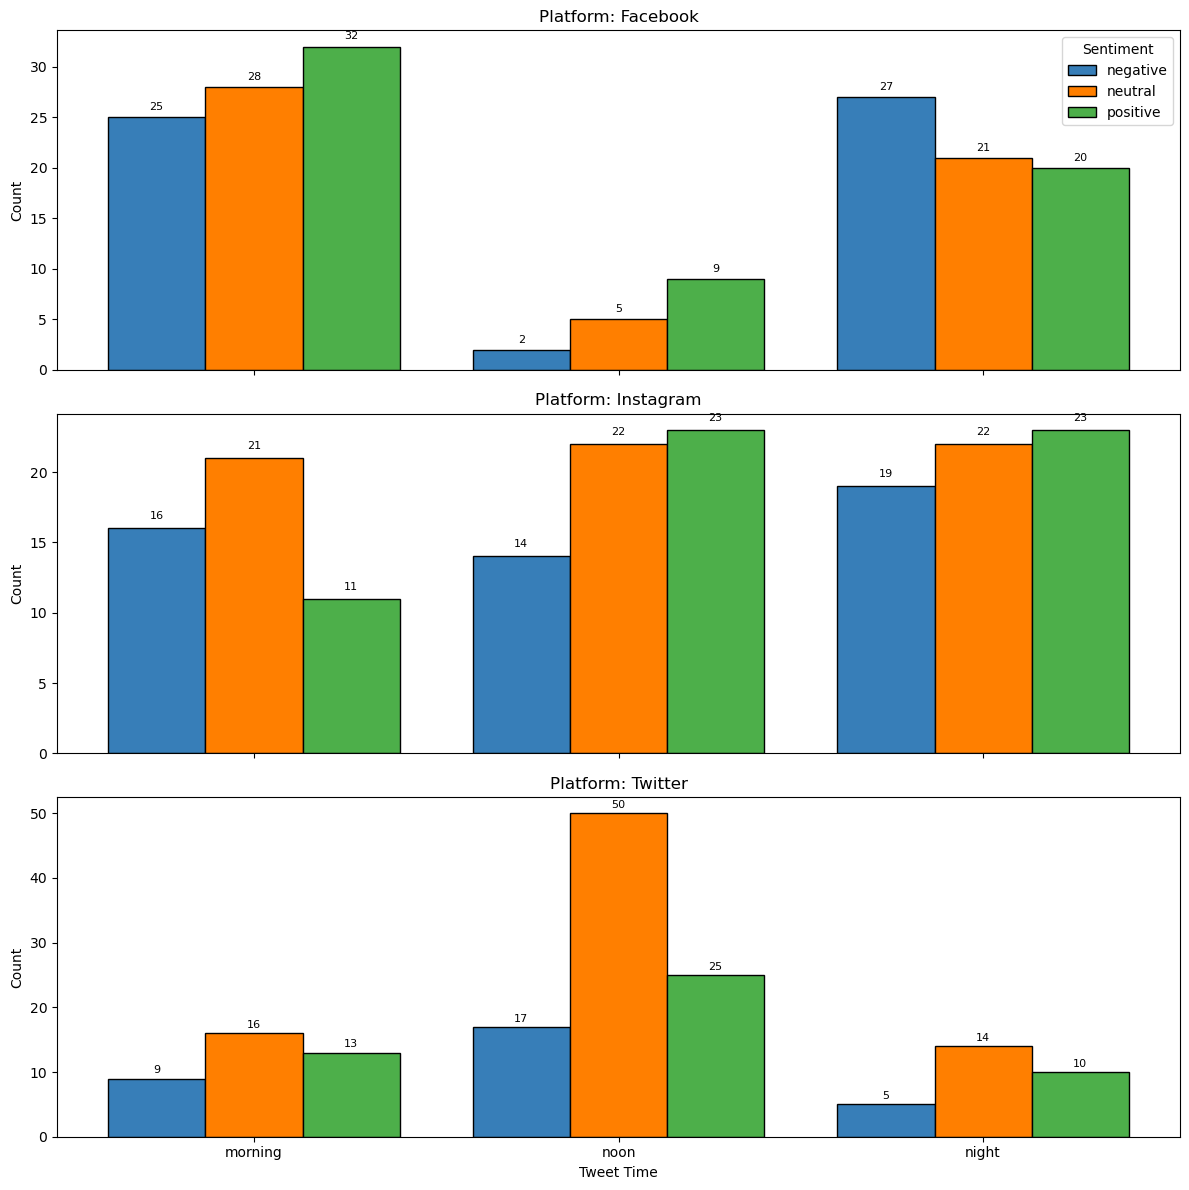

In [17]:
# Group by Platform, tweet_time, and sentiment, then pivot the data
import numpy as np
pivot_data = df.groupby(['Platform', 'Time of Tweet', 'sentiment']).size().unstack(fill_value=0)

# Get unique platforms and sentiment categories
platforms = pivot_data.index.get_level_values(0).unique()
sentiments = pivot_data.columns.tolist()
# Define the desired order for tweet_time categories
tweet_time_order = ['morning', 'noon', 'night']
# Define a custom color palette for the sentiment groups
custom_colors = ['#377eb8', '#ff7f00', '#4daf4a'] 

# Create a subplot for each platform
n_platforms = len(platforms)
fig, axs = plt.subplots(n_platforms, 1, figsize=(12, 4 * n_platforms), sharex=True)
if n_platforms == 1:
    axs = [axs]

for ax, platform in zip(axs, platforms):
        # Filter data for the current platform (result is a DataFrame with tweet_time as index)
    platform_data = pivot_data.loc[platform]
    # Reindex by tweet_time_order to enforce the desired order
    platform_data = platform_data.reindex(tweet_time_order, fill_value=0)
    
    # Define positions on the x-axis for each tweet_time category
    x = np.arange(len(platform_data.index))
    total_width = 0.8
    n = len(sentiments)
    bar_width = total_width / n
    
    # Plot each sentiment as a grouped bar
    for i, sentiment in enumerate(sentiments):
        offset = (i - n/2) * bar_width + bar_width/2
        counts = platform_data[sentiment].values
        ax.bar(x + offset, counts, width=bar_width, 
                label=sentiment if ax == axs[0] else "",
               color=custom_colors[i % len(custom_colors)], edgecolor='black')
        # Annotate each bar with its count
        for j, count in enumerate(counts):
            ax.text(x[j] + offset, count + 0.5, str(count), ha='center', va='bottom', fontsize=8)
    
    ax.set_title(f'Platform: {platform}')
    ax.set_ylabel('Count')
    ax.set_xticks(x)
    ax.set_xticklabels(platform_data.index, rotation=0)

plt.xlabel('Tweet Time')
axs[0].legend(title='Sentiment')
plt.tight_layout()
plt.show()

## Preprocess the sentiment data

In [24]:
!pip install contractions
!pip install emoji



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 3.1 MB/s eta 0:00:00-:--:--


In [27]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')  # Optional but recommended for better lemmatization
nltk.download('stopwords')  # Since you're using stopwords


[nltk_data] Downloading package wordnet to /Users/jibink/nltk_data...
[nltk_data] Downloading package omw-1.4 to /Users/jibink/nltk_data...
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jibink/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [28]:
# Initialize stopwords
import re
import emoji
import contractions
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def text_preprocessing(text):
    # Convert emojis to their text descriptions (e.g., 😊 -> :smiling_face_with_smiling_eyes:)
    text = emoji.demojize(text)
    
    # Replace common emoticons with textual labels
    emoticon_dict = {
        r":\)": " smile ",
        r":-\)": " smile ",
        r":\(": " sad ",
        r":-\(": " sad ",
        r";\)": " wink ",
        r";-\)": " wink ",
        r":D": " laugh ",
        r":-D": " laugh ",
        r":'\(": " cry ",
        r":-\/": " skeptical "
    }
    for pattern, replacement in emoticon_dict.items():
        text = re.sub(pattern, replacement, text)
        
    text = text.lower() # Convert to lowercase
    text = re.sub(r'\s+', ' ', text).strip()  # Normalize whitespace
    text = contractions.fix(text)  # Expand contractions (e.g., "don't" -> "do not")
    text = re.sub(r'\[.*?\]', '', text)  # Remove square brackets
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # Remove URLs
    text = re.sub(r'<.*?>+', '', text)  # Remove HTML tags
    text = re.sub(r'@\w+|#\w+', '', text)  # Remove mentions and hashtags (if not useful for sentiment)
    text = re.sub(r'\n', ' ', text)  # Replace new lines with space
    text = re.sub(r'\w*\d\w*', '', text)  # Remove words containing numbers
    text = re.sub(r'[^a-zA-Z!?]', ' ', text)  # Keep special sentiment-related symbols
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]  # Tokenize the text and remove stopwords
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    #text = ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])
    return " ".join(tokens) # text

df_processed = df.copy()
df_processed["text"] = df_processed["text"].astype(str).fillna("").apply(text_preprocessing)

# Encode sentiment labels
LE = LabelEncoder()
df_processed["Encoded sentiment"] = LE.fit_transform(df_processed["sentiment"])

df_processed.head()

,Year,Month,Day,Time of Tweet,text,sentiment,Platform,Encoded sentiment
0,2018,8,18,morning,great day!!! look like dream,positive,Twitter,2
1,2018,8,18,noon,feel sorry miss sea beach,positive,Facebook,2
2,2017,8,18,night,angry,negative,Facebook,0
3,2022,6,8,morning,attend class listening teacher reading slide n...,negative,Facebook,0
4,2022,6,8,noon,want go let go,negative,Instagram,0


## Feature Engineering:

In [29]:
vectorizer = TfidfVectorizer(ngram_range=(1,3), max_features=10000)  # Use unigrams, bigrams, and trigrams
X = vectorizer.fit_transform(df_processed['text'])
y = df_processed['Encoded sentiment']

# Split dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [39]:
!pip install bayesian-optimization
!pip install xgboost
!pip install lightgbm




   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 3.2 MB/s eta 0:00:00a 0:00:01


## Model Training and Hyperparameter Tuning

In [40]:
from bayes_opt import BayesianOptimization
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier



In [41]:
# === Optimize SVM (as before) ===
def optimize_svm(C, gamma):
    model = SVC(C=C, gamma=gamma, kernel='rbf')
    model.fit(X_train, y_train)
    return accuracy_score(y_test, model.predict(X_test))

svm_bo = BayesianOptimization(
    f=optimize_svm, 
    pbounds={"C": (0.1, 10), "gamma": (0.0001, 1)},
    random_state=42
)
svm_bo.maximize(n_iter=10)

best_svm = SVC(C=svm_bo.max["params"]["C"], gamma=svm_bo.max["params"]["gamma"], kernel="rbf")
best_svm.fit(X_train, y_train)

# === Optimize Random Forest ===
def optimize_rf(n_estimators, max_depth):
    model = RandomForestClassifier(
        n_estimators=int(n_estimators), 
        max_depth=int(max_depth), 
        random_state=42
    )
    model.fit(X_train, y_train)
    return accuracy_score(y_test, model.predict(X_test))

rf_bo = BayesianOptimization(
    f=optimize_rf, 
    pbounds={"n_estimators": (50, 500), "max_depth": (5, 30)},
    random_state=42
)
rf_bo.maximize(n_iter=10)

best_rf = RandomForestClassifier(
    n_estimators=int(rf_bo.max["params"]["n_estimators"]),
    max_depth=int(rf_bo.max["params"]["max_depth"]),
    random_state=42
)
best_rf.fit(X_train, y_train)

# === Optimize XGBoost ===
def optimize_xgb(n_estimators, max_depth, learning_rate, subsample, colsample_bytree):
    model = XGBClassifier(
         n_estimators=int(n_estimators),
         max_depth=int(max_depth),
         learning_rate=learning_rate,
         subsample=subsample,
         colsample_bytree=colsample_bytree,
         random_state=42,
         use_label_encoder=False,
         eval_metric='logloss'
    )
    model.fit(X_train, y_train)
    return accuracy_score(y_test, model.predict(X_test))

xgb_bo = BayesianOptimization(
    f=optimize_xgb,
    pbounds={
         "n_estimators": (50, 300),
         "max_depth": (3, 10),
         "learning_rate": (0.01, 0.3),
         "subsample": (0.5, 1.0),
         "colsample_bytree": (0.5, 1.0)
    },
    random_state=42
)
xgb_bo.maximize(n_iter=10)
best_xgb = XGBClassifier(
    n_estimators=int(xgb_bo.max["params"]["n_estimators"]),
    max_depth=int(xgb_bo.max["params"]["max_depth"]),
    learning_rate=xgb_bo.max["params"]["learning_rate"],
    subsample=xgb_bo.max["params"]["subsample"],
    colsample_bytree=xgb_bo.max["params"]["colsample_bytree"],
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)
best_xgb.fit(X_train, y_train)

# === Optimize LightGBM ===
def optimize_lgbm(n_estimators, max_depth, learning_rate, num_leaves):
    model = LGBMClassifier(
         n_estimators=int(n_estimators),
         max_depth=int(max_depth),
         learning_rate=learning_rate,
         num_leaves=int(num_leaves),
         random_state=42
    )
    model.fit(X_train, y_train)
    return accuracy_score(y_test, model.predict(X_test))

lgbm_bo = BayesianOptimization(
    f=optimize_lgbm,
    pbounds={
         "n_estimators": (50, 300),
         "max_depth": (3, 15),
         "learning_rate": (0.01, 0.3),
         "num_leaves": (20, 50)
    },
    random_state=42
)
lgbm_bo.maximize(n_iter=10)

best_lgbm = LGBMClassifier(
    n_estimators=int(lgbm_bo.max["params"]["n_estimators"]),
    max_depth=int(lgbm_bo.max["params"]["max_depth"]),
    learning_rate=lgbm_bo.max["params"]["learning_rate"],
    num_leaves=int(lgbm_bo.max["params"]["num_leaves"]),
    random_state=42
)
best_lgbm.fit(X_train, y_train)



|   iter    |  target   |     C     |   gamma   |
-------------------------------------------------
| 1         | 0.56      | 3.808     | 0.9507    |
| 2         | 0.59      | 7.347     | 0.5987    |
| 3         | 0.39      | 1.645     | 0.1561    |
| 4         | 0.46      | 0.675     | 0.8662    |
| 5         | 0.59      | 6.051     | 0.7081    |
| 6         | 0.56      | 9.756     | 0.9952    |
| 7         | 0.3       | 4.922     | 0.0001675 |
| 8         | 0.59      | 7.074     | 0.6658    |
| 9         | 0.56      | 8.489     | 0.9533    |
| 10        | 0.3       | 9.037     | 0.006093  |
| 11        | 0.58      | 6.608     | 0.0666    |
| 12        | 0.56      | 2.942     | 0.9993    |
| 13        | 0.3       | 3.221     | 0.01155   |
| 14        | 0.3       | 7.385     | 0.007862  |
| 15        | 0.61      | 6.455     | 0.4953    |
|   iter    |  target   | max_depth | n_esti... |
-------------------------------------------------
| 1         | 0.41      | 14.36     | 477.8     |


/opt/homebrew/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [23:51:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


| 1         | 0.57      | 0.6873    | 0.2857    | 8.124     | 199.7     | 0.578     |


/opt/homebrew/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [23:51:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


| 2         | 0.55      | 0.578     | 0.02684   | 9.063     | 200.3     | 0.854     |


/opt/homebrew/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [23:51:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


| 3         | 0.52      | 0.5103    | 0.2913    | 8.827     | 103.1     | 0.5909    |


/opt/homebrew/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [23:51:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


| 4         | 0.55      | 0.5917    | 0.09823   | 6.673     | 158.0     | 0.6456    |


/opt/homebrew/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [23:51:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


| 5         | 0.54      | 0.8059    | 0.05045   | 5.045     | 141.6     | 0.728     |


/opt/homebrew/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [23:51:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


| 6         | 0.57      | 0.6517    | 0.1952    | 7.374     | 199.2     | 0.5797    |


/opt/homebrew/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [23:51:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


| 7         | 0.56      | 0.9013    | 0.2107    | 8.17      | 197.6     | 0.5407    |


/opt/homebrew/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [23:51:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


| 8         | 0.56      | 0.6163    | 0.2059    | 6.313     | 201.1     | 0.5252    |


/opt/homebrew/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [23:51:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


| 9         | 0.56      | 0.996     | 0.2655    | 4.651     | 197.9     | 0.976     |


/opt/homebrew/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [23:51:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


| 10        | 0.54      | 0.558     | 0.2894    | 5.318     | 194.8     | 0.8205    |


/opt/homebrew/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [23:51:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


| 11        | 0.56      | 0.6546    | 0.1381    | 3.233     | 200.0     | 0.6698    |


/opt/homebrew/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [23:51:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


| 12        | 0.53      | 0.985     | 0.05747   | 3.153     | 203.1     | 0.8672    |


/opt/homebrew/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [23:51:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


| 13        | 0.56      | 0.6255    | 0.2579    | 6.178     | 277.7     | 0.7086    |


/opt/homebrew/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [23:51:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


| 14        | 0.56      | 0.5738    | 0.161     | 8.839     | 277.4     | 0.5576    |


/opt/homebrew/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [23:52:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


| 15        | 0.58      | 0.8872    | 0.1306    | 7.218     | 275.3     | 0.5277    |


/opt/homebrew/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [23:52:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


|   iter    |  target   | learni... | max_depth | n_esti... | num_le... |
-------------------------------------------------------------------------
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000163 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 47
[LightGBM] [Info] Number of data points in the train set: 399, number of used features: 5
[LightGBM] [Info] Start training from score -1.403994
[LightGBM] [Info] Start training from score -0.859063
[LightGBM] [Info] Start training from score -1.106159
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

LGBMClassifier(learning_rate=0.02427339825142482, max_depth=3, n_estimators=200,
               num_leaves=41, random_state=42)

In [42]:
def predict_traditional_model(text, model, vectorizer, label_encoder):
    """
    Predict sentiment using a traditional model (e.g., SVM, Random Forest, etc.).
    
    Parameters:
      text (str): The input sentence to classify.
      model: The trained traditional model (e.g., best_svm).
      vectorizer: The TF-IDF vectorizer used during training.
      label_encoder: The LabelEncoder used to encode sentiment labels.
      
    Returns:
      str: The predicted sentiment label.
    """
    # Preprocess the input
    processed_text = text_preprocessing(text)
    
    # Vectorize the preprocessed text
    text_vector = vectorizer.transform([processed_text])
    
    # Predict the sentiment class
    predicted_class = best_svm.predict(text_vector)[0]
    
    # Decode the numeric class back to the original sentiment label
    predicted_sentiment = label_encoder.inverse_transform([predicted_class])[0]
    return predicted_sentiment

In [43]:
# Example:
test_sentence = "I love it ! It works wonders and exceeded my expectations!"
predicted_sentiment = predict_traditional_model(test_sentence, best_svm, vectorizer, LE)
print("Input:", test_sentence)
print("Predicted Sentiment (Traditional Model):", predicted_sentiment)

Input: I love it ! It works wonders and exceeded my expectations!
Predicted Sentiment (Traditional Model): neutral


In [44]:
test_sentence = "The product is okay, but I've seen better."
predicted_sentiment = predict_traditional_model(test_sentence, best_svm, vectorizer, LE)
print("Input:", test_sentence)
print("Predicted Sentiment (Traditional Model):", predicted_sentiment)

Input: The product is okay, but I've seen better.
Predicted Sentiment (Traditional Model): neutral


In [45]:
test_sentence = "I really hate the service; it's terrible and disappointing."
predicted_sentiment = predict_traditional_model(test_sentence, best_svm, vectorizer, LE)
print("Input:", test_sentence)
print("Predicted Sentiment (Traditional Model):", predicted_sentiment)

Input: I really hate the service; it's terrible and disappointing.
Predicted Sentiment (Traditional Model): negative


In [47]:
!pip install transformers


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 5.0 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 12.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 10.5 MB/s eta 0:00:00a 0:00:01


In [49]:
!pip install tf-keras
!pip install keras==2.11.0
!pip install tensorflow==2.11.0


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 1.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 9.2 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: keras
    Found existing installation: keras 3.9.2
    Uninstalling keras-3.9.2:
      Successfully uninstalled keras-3.9.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.19.0 requires keras>=3.5.0, but you have keras 2.11.0 which is incompatible.
ERROR: Could not find a version that satisfies the requirement tensorflow==2.11.0 (from versions: 2.16.0rc0, 2.16.1, 2.16.2, 2.17.0rc0, 2.17.0rc1, 2.17.0, 2.17.1, 2.18.0rc0, 2.18.0rc1, 2.18.0rc2, 2.18.0, 2.18.1, 2.19.0rc0, 2.19.0)
ERROR: No matching distribution found for tensorflow==2.11.0


## Alternative Approach: Deep Learning with BERT

In [50]:
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification

# Load the pre-trained BERT tokenizer and model (for 3 sentiment classes)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

# Prepare texts and labels
texts = df_processed["text"].tolist()
labels = df_processed["Encoded sentiment"].values

# Tokenize texts using the BERT tokenizer
def tokenize_texts(texts, tokenizer, max_length=128):
    return tokenizer(
        texts,
        truncation=True,
        padding=True,
        max_length=max_length,
        return_tensors="tf"
    )

tokenized = tokenize_texts(texts, tokenizer, max_length=128)
# Convert the TF tensors to numpy arrays for train_test_split
input_ids = tokenized["input_ids"].numpy()
attention_mask = tokenized["attention_mask"].numpy()

# Split into training and test sets
train_inputs, test_inputs, train_masks, test_masks, train_labels, test_labels = train_test_split(
    input_ids, attention_mask, labels, test_size=0.2, random_state=42
)

# Create TensorFlow datasets
batch_size = 8
train_dataset = tf.data.Dataset.from_tensor_slices((
    {"input_ids": train_inputs, "attention_mask": train_masks},
    train_labels
)).shuffle(100).batch(batch_size)

test_dataset = tf.data.Dataset.from_tensor_slices((
    {"input_ids": test_inputs, "attention_mask": test_masks},
    test_labels
)).batch(batch_size)
# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)   
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

# Train the model
epochs = 3
history = model.fit(train_dataset, validation_data=test_dataset, epochs=epochs)

# Evaluate the model
results = model.evaluate(test_dataset)
print("Transformer Model Accuracy:", results[1])         

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3
50/50 [==============================] - 44s 697ms/step - loss: 1.0617 - accuracy: 0.4612 - val_loss: 1.0467 - val_accuracy: 0.4800
Epoch 2/3
50/50 [==============================] - 36s 713ms/step - loss: 0.8842 - accuracy: 0.5965 - val_loss: 0.8053 - val_accuracy: 0.5300
Epoch 3/3
13/13 [==============================] - 2s 143ms/step - loss: 0.6815 - accuracy: 0.7400
Transformer Model Accuracy: 0.7400000095367432


In [51]:
def predict_sentiment(text):
    # Tokenize the input text
    inputs = tokenizer(text, truncation=True, padding=True, max_length=128, return_tensors="tf")
    
    # Get model predictions (logits)
    logits = model(inputs).logits
    
    # Get the predicted class index (using argmax)
    predicted_class = tf.argmax(logits, axis=1).numpy()[0]
    
    # Convert the predicted class index back to the sentiment label using the LabelEncoder
    sentiment_label = LE.inverse_transform([predicted_class])[0]
    
    return sentiment_label

# Example: use the same example tested previously.
test_sentence = "I love it ! It works wonders and exceeded my expectations!"
predicted_sentiment = predict_sentiment(test_sentence)
print("Input:", test_sentence)
print("Predicted Sentiment (BERT):", predicted_sentiment)

Input: I love it ! It works wonders and exceeded my expectations!
Predicted Sentiment (BERT): positive


In [52]:
test_sentence = "The product is okay, but I've seen better."
predicted_sentiment = predict_sentiment(test_sentence)
print("Input:", test_sentence)
print("Predicted Sentiment (BERT):", predicted_sentiment)

Input: The product is okay, but I've seen better.
Predicted Sentiment (BERT): neutral


In [53]:
test_sentence = "I really hate the service; it's terrible and disappointing."
predicted_sentiment = predict_sentiment(test_sentence)
print("Input:", test_sentence)
print("Predicted Sentiment (BERT):", predicted_sentiment)

Input: I really hate the service; it's terrible and disappointing.
Predicted Sentiment (BERT): negative


# Conclusion:

- Best performance for traditional models is 0.61 (SVM), performance for transformer(BERT) is 0.74. BERT outperforms traditional models for this dataset.
- From the same example test resulst, Bert gave more accurate sentiment anlysis compared to TF-IDF + classical ML models.
- Tweaks that helped improve model accracy:
- Enahncing text preprocess function, including emoji/emoticons (this helps transformer accuracy boosting)
- Bayesian Optimization not really helpful in this case study.